If the Glove file is not in the directory. Otherwise skip the command line section.

In [ ]:
!wget "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
!unzip -j glove.twitter.27B.zip

In [1]:
import pandas as pd
import glob
import json
import numpy as np
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [2]:
classified = pd.read_csv('cleaned_data.csv')

In [3]:
classified = classified[['label','text']]
classified.text = classified.text.astype(str)

Use GloVe pretrained embeddings to seed embedding layer weights. Load GloVe weights trained on twitter dataset.

In [4]:
embeddings_idx = dict()
glove_file = open('glove.twitter.27B.100d.txt')
for line in glove_file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_idx[word] = coefs
glove_file.close()
print('Loaded %s word vectors.' % len(embeddings_idx))

Loaded 1193514 word vectors.


For simplicity, clump "depressed" and "suicidal" labels into one category (can refine this in future models/iteration; for first iteration, use binary classification):

In [6]:
text = np.asarray(classified.text)
label_binary = classified.label.replace(to_replace=3, value=1)
label = np.asarray(classified.label)

np.unique(label_binary)

array([0., 1.])

Tokenize tweet texts. Use a max sentence length of 50 (with char limit of 280 and cleaning, this seems reasonable - by observation, most tweets still require padding), and pad all tweets out to this length:

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
vocab_size = len(tokenizer.word_index) + 1
# integer encode the documents
encoded = tokenizer.texts_to_sequences(text)
# pad documents to a max length of 4 words
max_length = 50
padded_tweets = pad_sequences(encoded, maxlen=max_length, padding='post')

In [8]:
padded_tweets

array([[   9,    8,  814, ...,    0,    0,    0],
       [  34,   88,   90, ...,    0,    0,    0],
       [  14,  100,   53, ...,    0,    0,    0],
       ...,
       [  31,   18,  787, ...,    0,    0,    0],
       [ 693,  197,   12, ...,    0,    0,    0],
       [ 382,   10, 1009, ...,    0,    0,    0]], dtype=int32)

Split into train/test set of 90%/10%. These sets end up going unused, due to the cross fold validation, which splits the full dataset many times over.

In [9]:
text_train, text_test, label_train, label_test = train_test_split(padded_tweets, label_binary, test_size = 0.1, random_state = 0)

Split train set into train/validate. These sets end up going unused, due to the cross fold validation.

In [10]:
text_train, text_val, label_train, label_val = train_test_split(text_train, label_train, test_size = 0.2, random_state = 0)

Initialize embedding matrix to seed embedding weights from the loaded GloVe embeddings:

In [11]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Recall is extremely useful in such a problem where all efforts to avert a potential suicide is of utmost importance

In [12]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

K-fold cross validation was used to establish more confidence in the validation accuracy and validation recall for the model; the function below defined as cross_val(model) calculates an average validation accuracy and validation recall for the model over a k-way split of the data, along with a confidence interval. Due to computational resource limitations, as LSTM training requires a large amount of time, k is set to 4.


Add the data for each model along with model names, so that models can be compared, to lists.

In [28]:
model_names = {}
model_acc = {}
model_recall = {}
model_acc_conf = {}
model_recall_conf = {}

In [29]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

def train_model(model, text_train=text_train, label_train=label_train, text_val=text_val, label_val=label_val, callbacks = callbacks, verbose = 1, class_weight = None):
        history = model.fit(text_train, label_train, batch_size = 32, validation_data = (text_val, label_val), epochs = 50, callbacks = callbacks, verbose = verbose, class_weight = class_weight)
        return history

skf = StratifiedKFold(n_splits = 4)




def cross_val(model, text, label, callbacks = callbacks, skf = skf, verbose = 0, class_weight = None):
    cvaccscores = []
    cvrecscores = []
    for TRAIN, TEST in skf.split(text, label):
        text_train, text_val = text[TRAIN], text[TEST]
        label_train, label_val = label[TRAIN], label[TEST]
        history = train_model(model[0], verbose = verbose, class_weight = class_weight)
        val_recall = history.history['val_recall_m'][-1]*100
        val_acc = history.history['val_acc'][-1]*100
        print("Acc:{}".format(val_acc))
        print("Recall:{}".format(val_recall))
        cvrecscores.append(val_recall)
        cvaccscores.append(val_acc)

    print("Acc_overall: %.2f%% (+/- %.2f%%)" % (np.mean(cvaccscores), np.std(cvaccscores)))
    print("Recall_overall: %.2f%% (+/- %.2f%%)" % (np.mean(cvrecscores), np.std(cvrecscores)))
    model_acc[model[1]]= np.mean(cvaccscores)
    model_acc_conf[model[1]] = np.std(cvaccscores)
    model_recall[model[1]]= np.mean(cvrecscores)
    model_recall_conf[model[1]]= np.std(cvrecscores)
        

# LSTM

In [21]:
def lstm_50_no_dropout_one_dense():
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False))
    model.add(LSTM(50))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])
    return model, 'LSTM 50 Units No Dropout and One Dense Layer'

def lstm_75_no_dropout_one_dense():
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False))
    model.add(LSTM(75))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])
    return model, 'LSTM 75 Units No Dropout and One Dense Layer'

def lstm_50_0_2_dropout_one_dense():
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(50, dropout = 0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])
    return model, 'LSTM 50 Units 0.2 Dropout and One Dense Layer'

def lstm_75_0_2_dropout_one_dense():
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(75, dropout = 0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])
    return model, 'LSTM 75 Units 0.2 Dropout and One Dense Layer'


def lstm_75_0_2_dropout_two_dense():
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(75, dropout = 0.2, recurrent_dropout=0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])
    return model, 'LSTM 75 Units 0.2 Dropout and Two Dense Layer'

def lstm_50_0_2_dropout_two_dense():
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(50, dropout = 0.2, recurrent_dropout=0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])
    return model, 'LSTM 50 Units 0.2 Dropout and Two Dense Layer'


def bi_lstm_50_0_2_dropout_one_dense():
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(50, dropout = 0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])
    return model, 'Bidirectional LSTM 50 Units 0.2 Dropout and One Dense Layer'

def bi_lstm_75_0_2_dropout_one_dense():
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(75, dropout = 0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])
    return model, 'Bidirectional LSTM 75 Units 0.2 Dropout and One Dense Layer'

def bi_lstm_50_0_2_dropout_two_dense():
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(50, dropout = 0.2, recurrent_dropout=0.2)))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])
    return model, 'Bidirectional LSTM 50 Units 0.2 Dropout and Two Dense Layer'

def bi_lstm_75_0_2_dropout_two_dense():
    model = Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(75, dropout = 0.2, recurrent_dropout=0.2)))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall_m ])
    return model, 'Bidirectional LSTM 75 Units 0.2 Dropout and Two Dense Layer'


In [43]:
cross_val(lstm_50_0_2_dropout_one_dense(), padded_tweets, label_binary)
cross_val(lstm_75_0_2_dropout_one_dense(), padded_tweets, label_binary)
cross_val(lstm_75_0_2_dropout_two_dense(), padded_tweets, label_binary)
cross_val(lstm_50_0_2_dropout_two_dense(), padded_tweets, label_binary)
cross_val(bi_lstm_50_0_2_dropout_one_dense(), padded_tweets, label_binary)
cross_val(bi_lstm_75_0_2_dropout_one_dense(), padded_tweets, label_binary)
cross_val(bi_lstm_50_0_2_dropout_two_dense(), padded_tweets, label_binary)
cross_val(bi_lstm_75_0_2_dropout_two_dense(), padded_tweets, label_binary)


W0803 16:03:06.501801 4506400192 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Acc:79.48964851144764
Recall:50.10478821119897
Acc:80.01925855171928
Recall:47.23585286448079
Acc:80.30813671558823
Recall:50.270661078913605
Acc:81.60808862087873
Recall:44.949476504819465
Acc_overall: 80.36% (+/- 0.78%)
Recall_overall: 48.14% (+/- 2.20%)
Acc:80.50072223278096
Recall:40.67082244384501
Acc:80.21184398568934
Recall:47.27394667794398
Acc:81.12662494555653
Recall:44.48035223356622
Acc:79.44150217232591
Recall:58.56863113051145
Acc_overall: 80.32% (+/- 0.61%)
Recall_overall: 47.75% (+/- 6.67%)
Acc:79.39335581311596
Recall:0.0
Acc:79.15262396254101
Recall:38.571664468565984
Acc:79.24891666661217
Recall:34.3223626862137
Acc:79.10447759759155
Recall:50.07524779626941
Acc_overall: 79.22% (+/- 0.11%)
Recall_overall: 30.74% (+/- 18.66%)
Acc:80.25999035063877
Recall:51.11305177297854
Acc:81.07847861217431
Recall:32.594884033092924
Acc:79.77852670114432
Recall:53.07855233872918
Acc:80.2599903764665
Recall:53.330494801356465
Acc_overall: 80.34% (+/- 0.47%)
Recall_overall: 47.53% (+

W0803 16:48:04.621299 4506400192 legend.py:1289] No handles with labels found to put in legend.


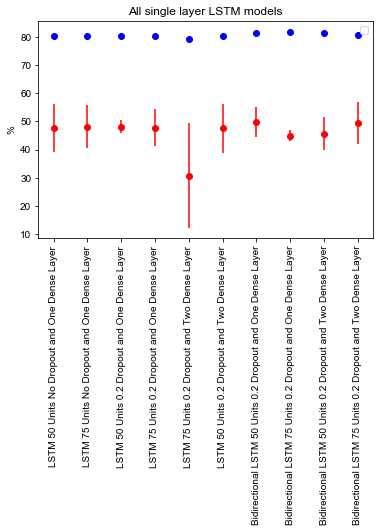

In [44]:
#all models
import matplotlib.pyplot as plt

model_acc_list = []
model_acc_conf_list = []
model_recall_list = []
model_recall_conf_list = []
model_names = []

for name in model_acc:
    model_acc_list.append(model_acc[name])
    model_acc_conf_list.append(model_acc_conf[name])
    model_recall_list.append(model_recall[name])
    model_recall_conf_list.append(model_recall_conf[name])
    model_names.append(name)

x = list(range(0,len(model_names)))
#plt.plot(x, model_acc, 'bo', label='Accuracy')
#plt.plot(x, model_recall, 'ro', label='Recall')
plt.errorbar(x, model_acc_list, yerr=model_acc_conf_list, fmt = 'bo')
plt.errorbar(x, model_recall_list, yerr=model_recall_conf_list, fmt = 'ro')
plt.xticks(x,model_names,rotation='vertical')
plt.title('All single layer LSTM models')
plt.ylabel('%')
plt.legend()
plt.show()

Try Class weight for the best performing models. Classweight of 1:3 first

In [49]:
model_names = {}
model_acc = {}
model_recall = {}
model_acc_conf = {}
model_recall_conf = {}

cross_val(bi_lstm_75_0_2_dropout_two_dense(), padded_tweets, label_binary, class_weight = {0:1.,1:3.})
cross_val(bi_lstm_50_0_2_dropout_one_dense(), padded_tweets, label_binary, class_weight = {0:1.,1:3.})
cross_val(lstm_50_0_2_dropout_one_dense(), padded_tweets, label_binary, class_weight = {0:1.,1:3.})

Acc:74.38613388420127
Recall:70.80832452916387
Acc:76.31198842478419
Recall:71.63307922759995
Acc:76.0712566574319
Recall:65.84869053539428
Acc:77.75637943066252
Recall:64.80444934601157
Acc_overall: 76.13% (+/- 1.20%)
Recall_overall: 68.27% (+/- 2.98%)
Acc:71.01588828608459
Recall:77.28389878656408
Acc:72.21954743564847
Recall:74.42201757637652
Acc:76.93789117486648
Recall:67.38974447427142
Acc:71.97881563672895
Recall:74.39187196337609
Acc_overall: 73.04% (+/- 2.30%)
Recall_overall: 73.37% (+/- 3.65%)
Acc:71.11218101598348
Recall:75.32972667615574
Acc:70.43813188086351
Recall:82.6429948361378
Acc:76.93789119495472
Recall:70.71675230633713
Acc:70.43813193251896
Recall:81.81621760890411
Acc_overall: 72.23% (+/- 2.73%)
Recall_overall: 77.63% (+/- 4.89%)


W0803 18:03:11.178001 4506400192 legend.py:1289] No handles with labels found to put in legend.


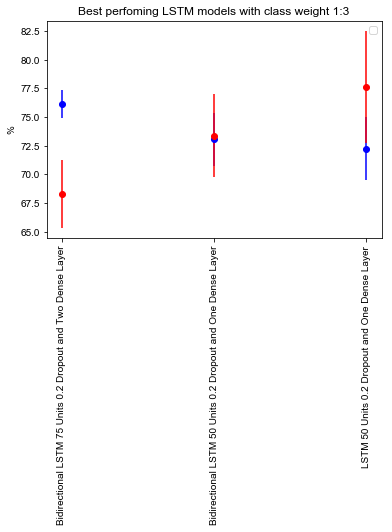

In [50]:
model_acc_list = []
model_acc_conf_list = []
model_recall_list = []
model_recall_conf_list = []
model_names = []

for name in model_acc:
    model_acc_list.append(model_acc[name])
    model_acc_conf_list.append(model_acc_conf[name])
    model_recall_list.append(model_recall[name])
    model_recall_conf_list.append(model_recall_conf[name])
    model_names.append(name)

x = list(range(0,len(model_names)))
#plt.plot(x, model_acc, 'bo', label='Accuracy')
#plt.plot(x, model_recall, 'ro', label='Recall')
plt.errorbar(x, model_acc_list, yerr=model_acc_conf_list, fmt = 'bo')
plt.errorbar(x, model_recall_list, yerr=model_recall_conf_list, fmt = 'ro')
plt.xticks(x,model_names,rotation='vertical')
plt.title('Best perfoming LSTM models with class weight 1:3')
plt.ylabel('%')
plt.legend()
plt.show()

In [51]:
model_names = {}
model_acc = {}
model_recall = {}
model_acc_conf = {}
model_recall_conf = {}

cross_val(bi_lstm_75_0_2_dropout_two_dense(), padded_tweets, label_binary, class_weight = {0:1.,1:6.})
cross_val(bi_lstm_50_0_2_dropout_one_dense(), padded_tweets, label_binary, class_weight = {0:1.,1:6.})
cross_val(lstm_50_0_2_dropout_one_dense(), padded_tweets, label_binary, class_weight = {0:1.,1:6.})

Acc:52.81656232084514
Recall:95.4821662370207
Acc:66.10495904115284
Recall:83.87196742403547
Acc:56.23495428391128
Recall:92.21940653566334
Acc:68.51227728288565
Recall:82.13093839818949
Acc_overall: 60.92% (+/- 6.56%)
Recall_overall: 88.43% (+/- 5.58%)
Acc:64.08281171327609
Recall:86.68126963513025
Acc:66.58642274230274
Recall:83.31194116797192
Acc:65.71978814738499
Recall:84.3531253192077
Acc:65.91237360718276
Recall:83.08859844878137
Acc_overall: 65.58% (+/- 0.92%)
Recall_overall: 84.36% (+/- 1.42%)
Acc:55.94607603681966
Recall:94.45504375415521
Acc:62.78285991129648
Recall:90.54360736374908
Acc:65.43090992612109
Recall:87.14493240481337
Acc:65.67164180826326
Recall:85.40677239129218
Acc_overall: 62.46% (+/- 3.93%)
Recall_overall: 89.39% (+/- 3.46%)


W0803 18:18:07.381018 4506400192 legend.py:1289] No handles with labels found to put in legend.


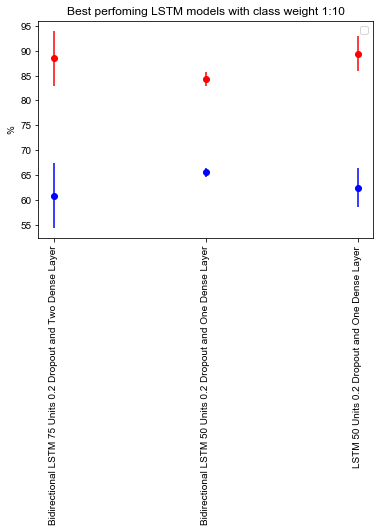

In [52]:
model_acc_list = []
model_acc_conf_list = []
model_recall_list = []
model_recall_conf_list = []
model_names = []

for name in model_acc:
    model_acc_list.append(model_acc[name])
    model_acc_conf_list.append(model_acc_conf[name])
    model_recall_list.append(model_recall[name])
    model_recall_conf_list.append(model_recall_conf[name])
    model_names.append(name)

x = list(range(0,len(model_names)))
#plt.plot(x, model_acc, 'bo', label='Accuracy')
#plt.plot(x, model_recall, 'ro', label='Recall')
plt.errorbar(x, model_acc_list, yerr=model_acc_conf_list, fmt = 'bo')
plt.errorbar(x, model_recall_list, yerr=model_recall_conf_list, fmt = 'ro')
plt.xticks(x,model_names,rotation='vertical')
plt.title('Best perfoming LSTM models with class weight 1:10')
plt.ylabel('%')
plt.legend()
plt.show()